In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from properscoring import crps_gaussian
import datetime

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data, train_test_normalise
from useful_fun import plot_sliding_window, number_outof_CI, split_dataframe_by_position


In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data) # y is unnormalised: good!

# get date for x-axis in plots: mm-yyyy
def get_xticks(df):
    dff = df.groupby(by='m-y').first()
    pos = dff.ids; pos = pos[1:]
    labels = dff.index; labels = labels[1:]
    return pos, labels

2022-08-29 11:11:18.063075: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 11:11:18.682523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


# Sliding Window
### Two-latent function model with VGP

        y = f(x) + g(x) + e
        f = GP(0, RBF)
        g = GP(0, Periodic)

        l = InvGama()
        sigma = Gamma()

In [6]:
def optimise_model(model, epochs=50):

    set_trainable(model.q_mu, False)
    set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(model.training_loss, variational_vars)
        adam_opt.minimize(model.training_loss, adam_vars)

    for epoch in range(1, epochs + 1):
        optimisation_step()

In [28]:
def slidingwindow_alg(splits, window_size, epochs=50, l0=77, p=365, l1=30):    
    split_dataframes = split_dataframe_by_position(data, splits)

    # evaluation lists
    ELBO_train = []
    mse_train = []; mae_train = []; n_outof_CI_train = []
    mse_test = [];  mae_test = [];  n_outof_CI_test = []
    crps_train = []; crps_test = []

    # window sizes
    iterations = splits-window_size

    # which iteration to plot
    iteration_plot = [int(floor(iterations/2)), iterations-1]
    print('iterations to go through, plot: ', iterations, iteration_plot)

    for i in range(splits-window_size):
        # create new dataframe
        df = pd.DataFrame()

        # select data
        for df_ind in range(window_size):
            if df_ind == 0:
                df = split_dataframes[i]
            else :
                df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

        whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
        pos, labels = get_xticks(whole_data)

        # normalise & separate data
        df_train = df; df_test = split_dataframes[i+window_size]
        df_train, df_test = train_test_normalise(df_train, df_test)
        x_train, y_train = separate_data(df_train)
        x_test, y_test = separate_data(df_test)
        
        # build model
        if i == 0:
            kernel = gpflow.kernels.RBF(lengthscales = l0, variance = 1) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(lengthscales=l1), period=p)
        else:
            # re-optimize from starting values = optimizes hyperparameters in previous window
            kernel = gpflow.kernels.RBF(lengthscales = l_0, variance = v0) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(lengthscales=l1, variance=v1), period=p_1)
        model = gpflow.models.VGP((x_train, y_train), kernel, gpflow.likelihoods.Gaussian(), num_latent_gps=1)
        if i != 0: 
            model.q_mu.assign(q_mu)
            model.q_sqrt.assign(q_sqrt)
            model.likelihood.variance.assign(v)
        model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
        model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].period.prior = tfp.distributions.Uniform(to_default_float(0), to_default_float(1))

        # optimise/train step
        optimise_model(model, epochs=epochs)

        # save hyperparameters
        l_0 = model.kernel.kernels[0].lengthscales.numpy()
        l1 = model.kernel.kernels[1].base_kernel.lengthscales.numpy()
        v0 = model.kernel.kernels[0].variance.numpy()
        v1 = model.kernel.kernels[1].base_kernel.variance.numpy()
        p_1 = model.kernel.kernels[1].period.numpy()
        q_mu = model.q_mu.numpy(); q_sqrt = model.q_sqrt.numpy()
        v = model.likelihood.variance.numpy()

        # predict
        mean_train, var_train = model.predict_y(x_train)
        mean_test, var_test = model.predict_y(x_test)

        # evaluate
        ELBO_train.append(model.elbo().numpy())
        mse_train.append(mean_squared_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
        mse_test.append(mean_squared_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))
        crps_train.append(np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train)))); crps_test.append(np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))))

        if i in iteration_plot:
            plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=i)
        

    # Average evaluation metrics
    print('ELBO Avg: ', np.mean(ELBO_train))
    print('Train Avg. MSE, points outside CI: ', np.mean(mse_train), np.mean(n_outof_CI_train))
    print('Test Avg. MSE, points outside CI: ', np.mean(mse_test),  np.mean(n_outof_CI_test))
    print('CRPS train, test: ', np.mean(crps_train), np.mean(crps_test))

    # histogram of CI
    fig, ax = plt.subplots(1,2)
    ax[0].hist(n_outof_CI_train, bins=50)
    ax[0].set_title('Train')
    ax[1].hist(n_outof_CI_test, bins=50)
    ax[1].set_title('Test')
    plt.title('Histogram of number of points that lie outside 95% CI')
    plt.show()

    # evolution of metrics
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].plot(np.linspace(1,iterations, iterations), mse_train, '-', color='C0')
    ax[0].plot(np.linspace(1,iterations, iterations), mse_test, '-', color='orange')
    ax[0].set_ylabel('MSE')
    ax[0].set_xlabel('Windows')
    ax[1].plot(np.linspace(1,iterations, iterations), crps_train, '-', color='C0', label='Train set')
    ax[1].plot(np.linspace(1,iterations, iterations), crps_test, '-', color='orange', label='Test set')
    ax[1].set_ylabel('CRPS')
    ax[1].set_xlabel('Windows')
    plt.legend()
    plt.show()

    return print_summary(model, fmt='notebook')

iterations to go through, plot:  54 [27, 53]


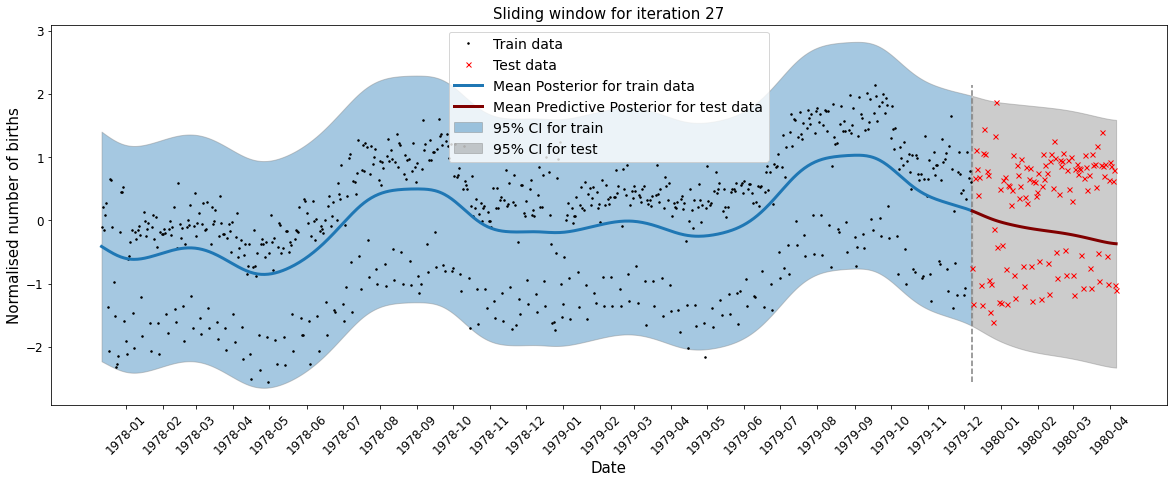

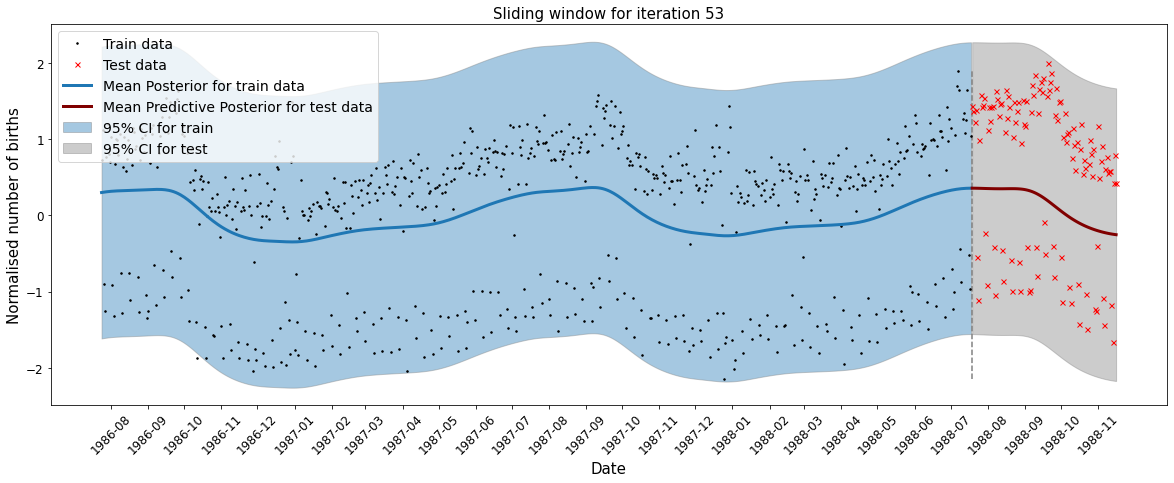

ELBO Avg:  -969.83986345223
Train Avg. MSE, points outside CI:  0.7889796167701137 5.777777777777778
Test Avg. MSE, points outside CI:  1.0231802000753294 1.1481481481481481
CRPS train, test:  0.512123660182018 0.588550346842121


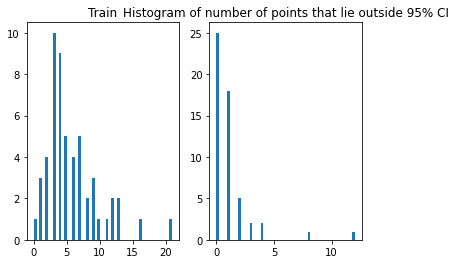

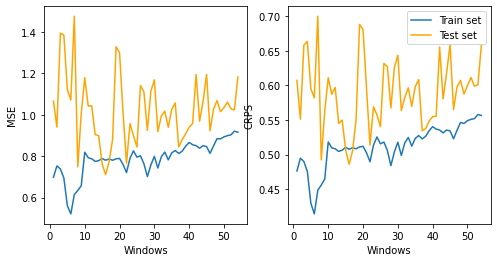

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.007285584849303596
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,34.20341512840657
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.06779075369639673
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.50866490283336
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,356.82131321961685
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9408702844983783
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[1.10001184e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[4.35503210e-01, 0.00000000e+00, 0.00000000e+00..."


In [15]:
slidingwindow_alg(60, 6, epochs=30, l0=30, p=365, l1=1)

iterations to go through, plot:  54 [27, 53]


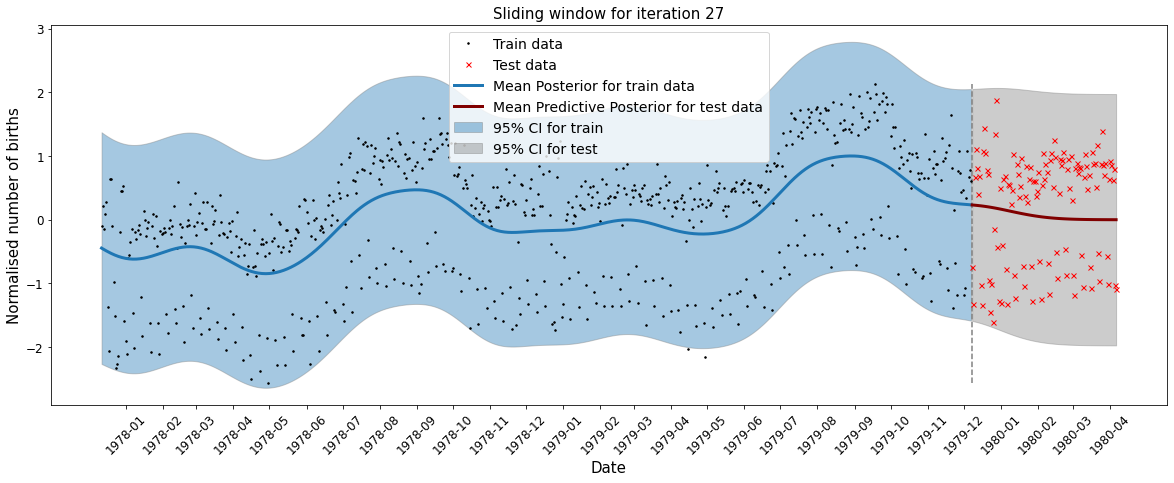

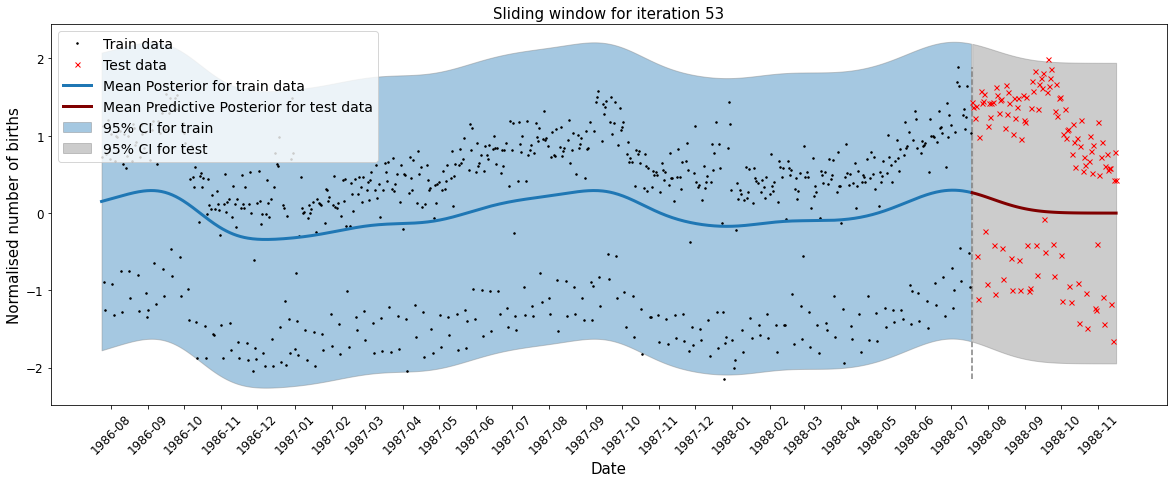

ELBO Avg:  -972.0275408559736
Train Avg. MSE, points outside CI:  0.7915070460772041 5.888888888888889
Test Avg. MSE, points outside CI:  1.0728623992389752 2.1666666666666665
CRPS train, test:  0.5129723741222487 0.59982027140747


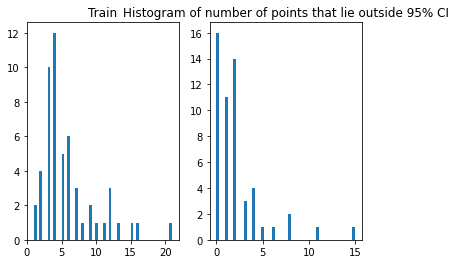

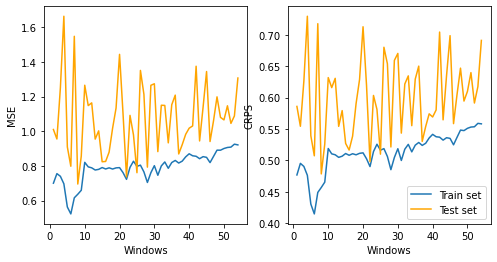

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.0404380431673538
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,31.408060633650756
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,8.066214518652449e-06
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,13.813990961924254
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,70.5631664987003
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9431079225207903
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[7.49600946e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[7.32499457e-01, 0.00000000e+00, 0.00000000e+00..."


In [29]:
slidingwindow_alg(60, 6, epochs=30, l0=30, p=77, l1=30)

iterations to go through, plot:  54 [27, 53]


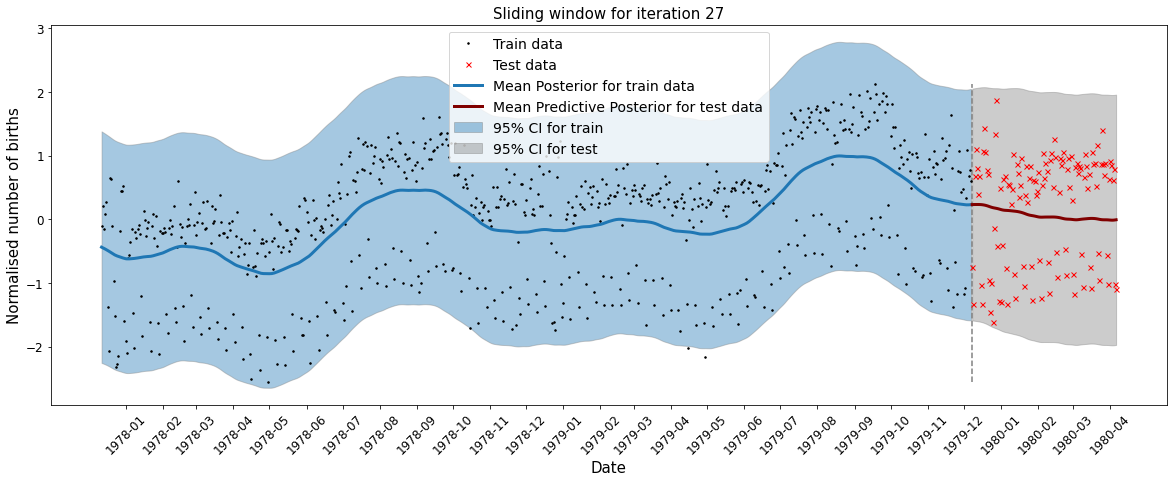

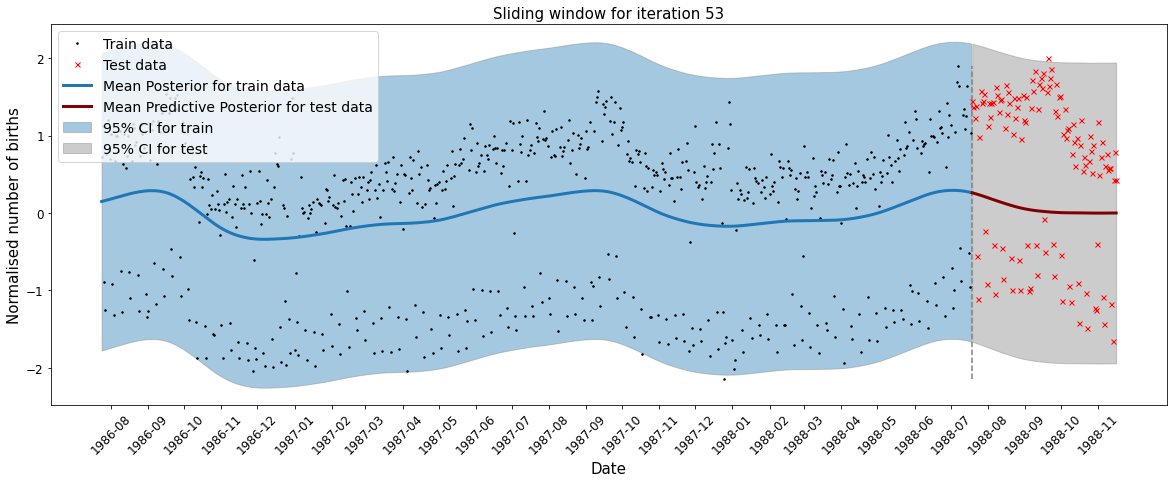

ELBO Avg:  -972.2278058751364
Train Avg. MSE, points outside CI:  0.7906870453074182 5.851851851851852
Test Avg. MSE, points outside CI:  1.0724857757297581 2.1481481481481484
CRPS train, test:  0.5126867784887875 0.5997335147334438


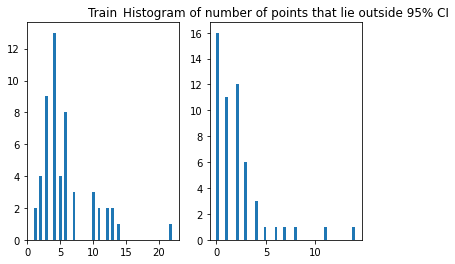

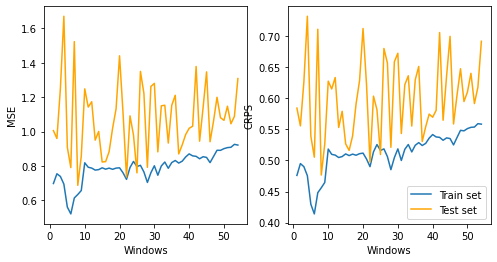

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.03981878065225324
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,31.151527155755083
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.00010176678957713539
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.5037966773134235
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,30.454615983773483
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9431530711720043
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[7.47851068e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[7.36089623e-01, 0.00000000e+00, 0.00000000e+00..."


In [30]:
slidingwindow_alg(60, 6, epochs=30, l0=30, p=30, l1=7)

iterations to go through, plot:  54 [27, 53]


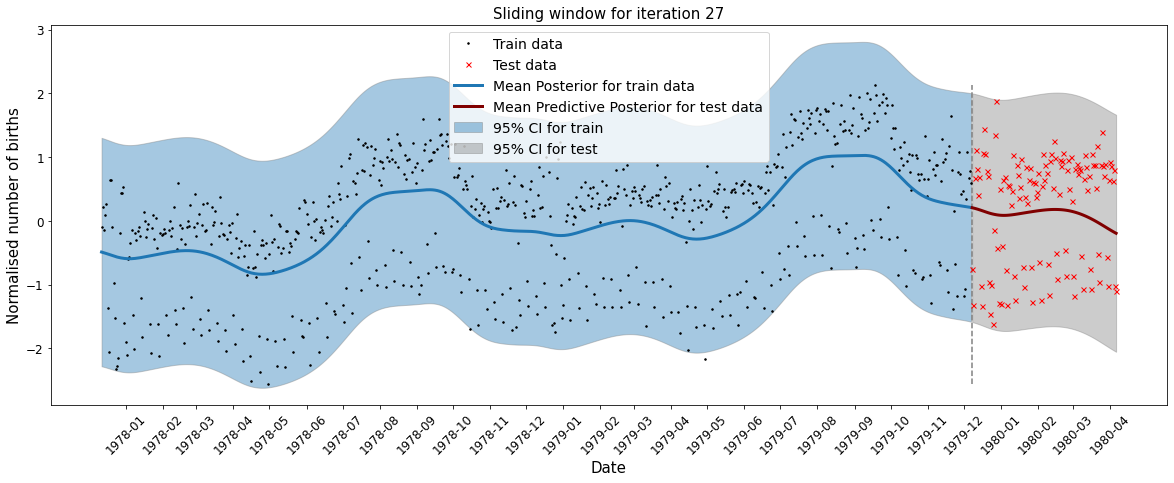

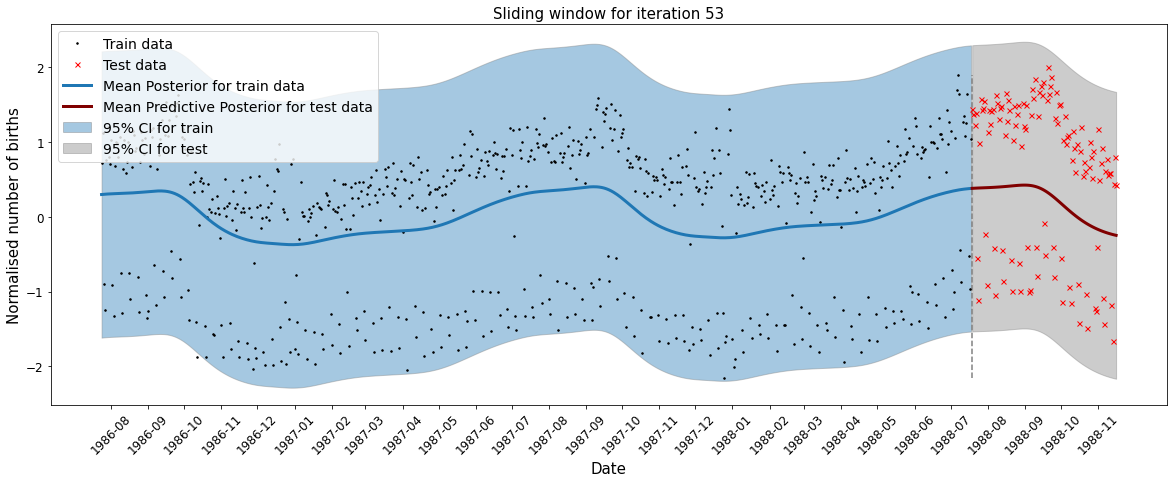

ELBO Avg:  -965.0811042636216
Train Avg. MSE, points outside CI:  0.7912615735497598 7.148148148148148
Test Avg. MSE, points outside CI:  0.8983499340807017 1.537037037037037
CRPS train, test:  0.5127603082789922 0.549913533910641


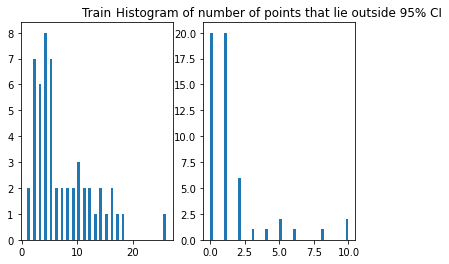

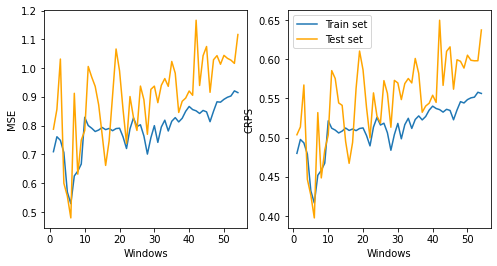

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.004905895928709812
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,164.94257753936552
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.16799806765710376
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.683526163352429
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,360.31914238776443
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9392421880147193
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[7.14808678e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[2.68392826e-01, 0.00000000e+00, 0.00000000e+00..."


In [18]:
slidingwindow_alg(60, 6, epochs=30, l0=170, p=365)

iterations to go through, plot:  54 [27, 53]


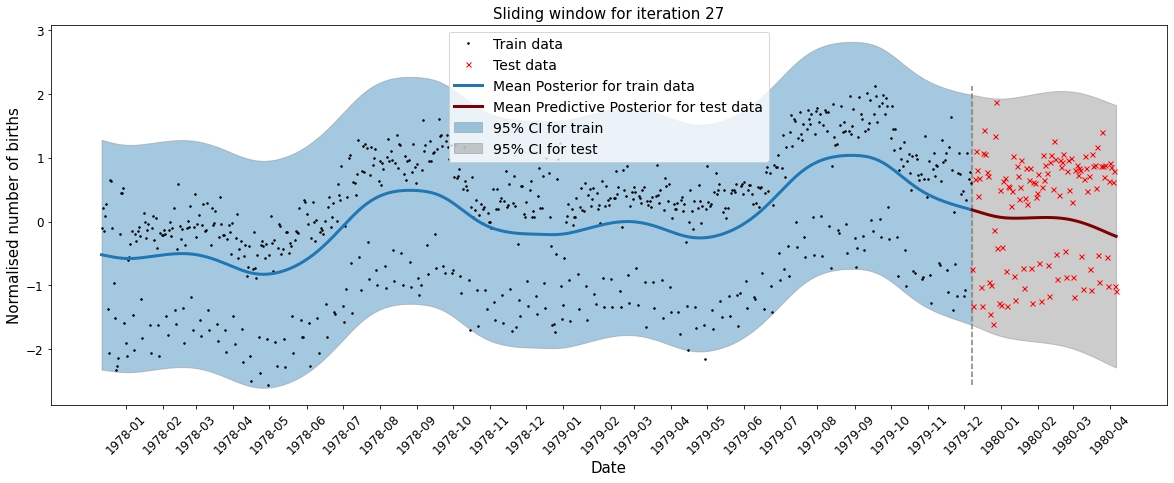

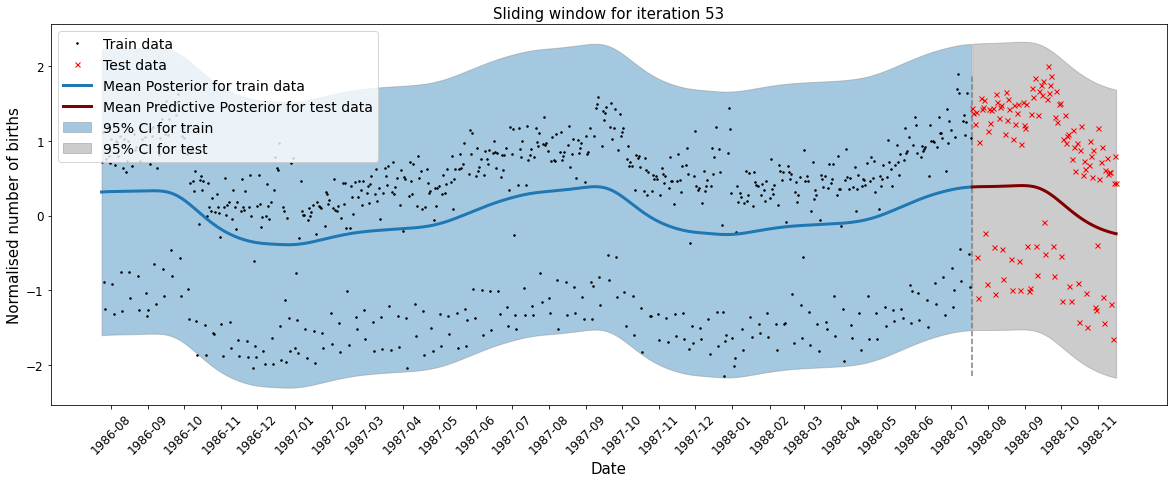

ELBO Avg:  -966.8374291998788
Train Avg. MSE, points outside CI:  0.7925114212957184 7.055555555555555
Test Avg. MSE, points outside CI:  0.9579415110663726 1.2407407407407407
CRPS train, test:  0.5132070137585403 0.5676730920043317


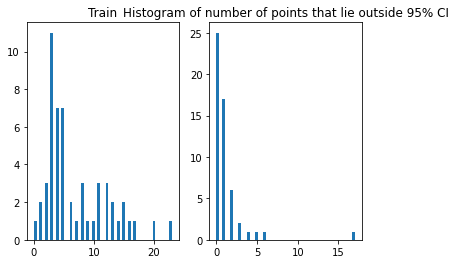

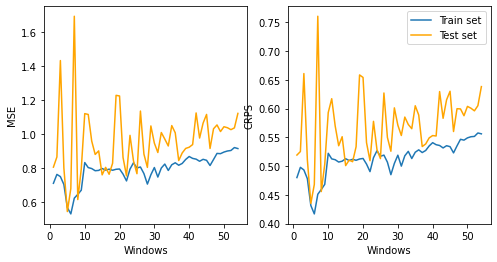

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.012354973501338486
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,65.07317936182427
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.09966318693937865
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.5979348433019241
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,361.1545248947316
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9394363447840142
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[9.44719624e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[3.81733581e-01, 0.00000000e+00, 0.00000000e+00..."


In [19]:
slidingwindow_alg(60, 6, epochs=30, l0=77, p=365)

iterations to go through, plot:  54 [27, 53]


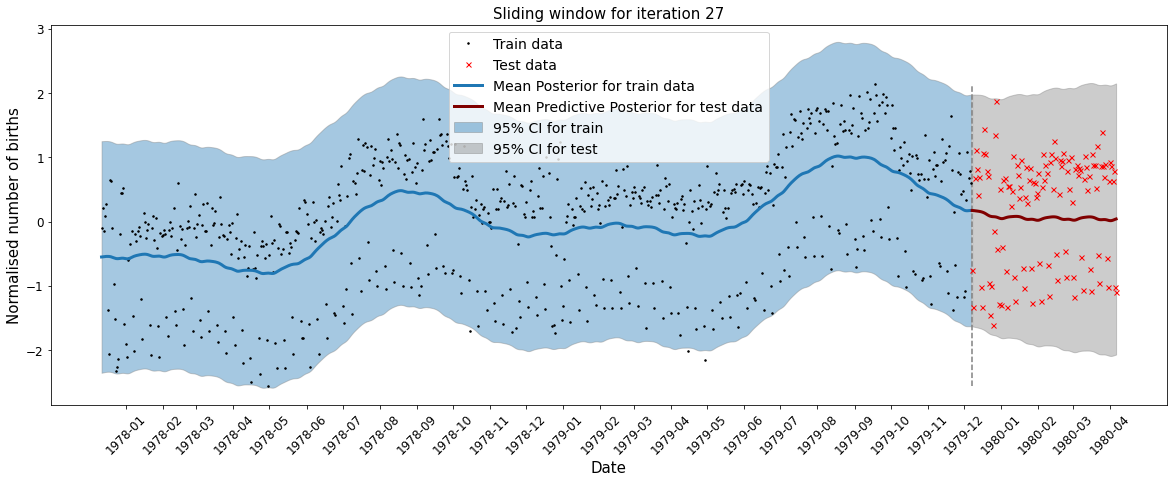

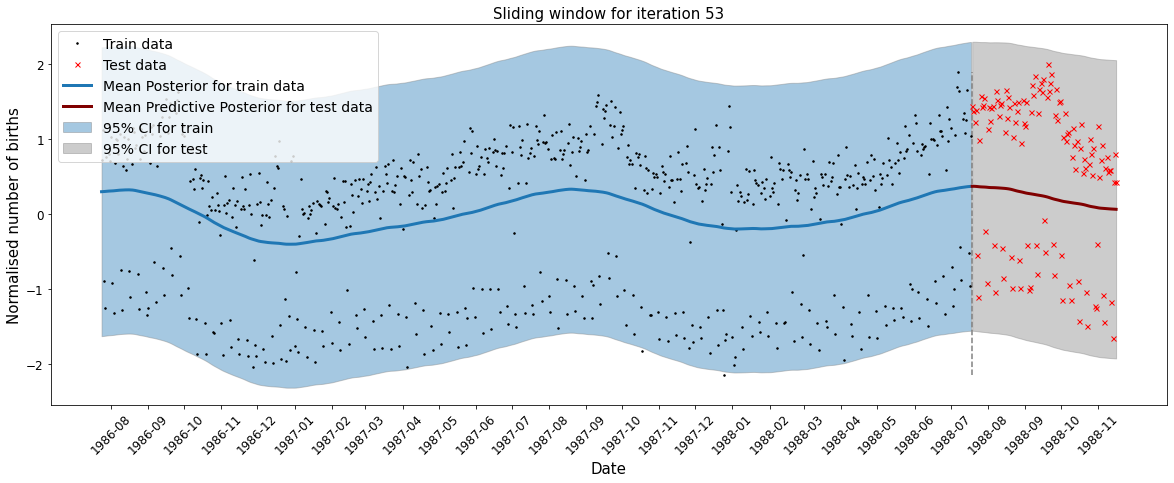

ELBO Avg:  -969.8594410776578
Train Avg. MSE, points outside CI:  0.797957003391671 7.666666666666667
Test Avg. MSE, points outside CI:  1.03755522442923 2.0555555555555554
CRPS train, test:  0.5148574056947075 0.5868704920634985


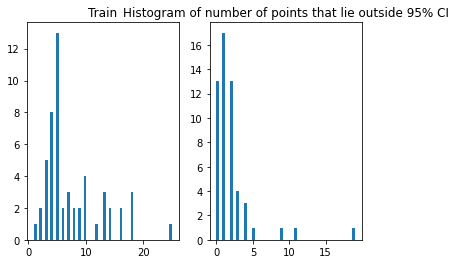

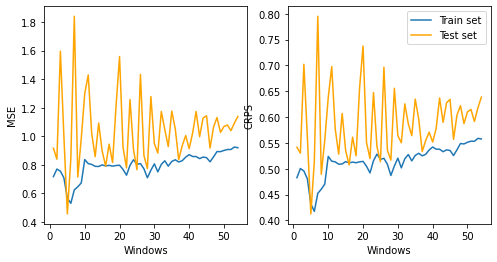

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.08808921773980734
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,64.89308859610512
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.0007452717116506224
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.5096829418925027
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,30.476611033247888
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.941138817773155
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[9.97099620e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[5.15267168e-01, 0.00000000e+00, 0.00000000e+00..."


In [20]:
slidingwindow_alg(60, 6, epochs=30, l0=77, p=30)

iterations to go through, plot:  54 [27, 53]


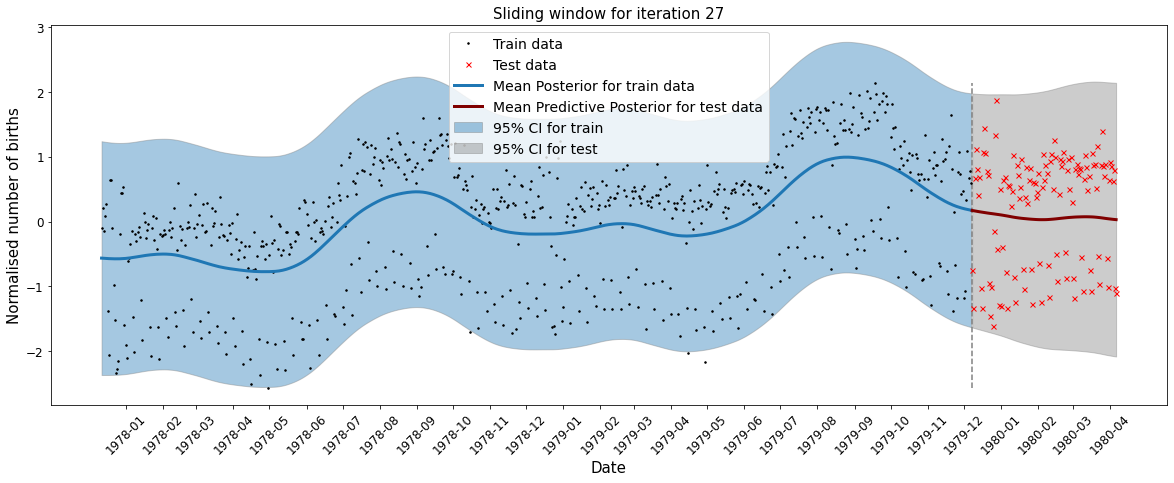

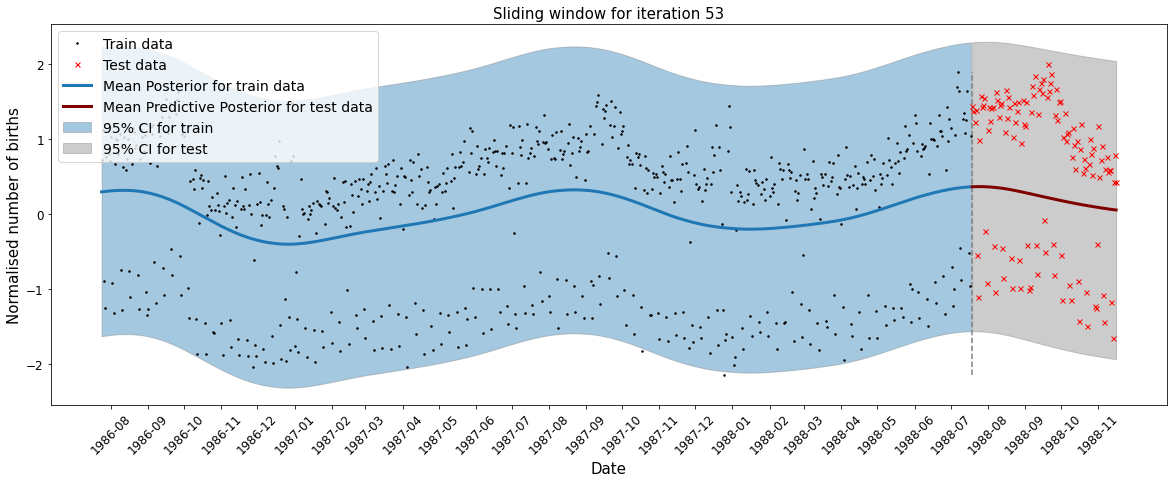

ELBO Avg:  -969.5909619157782
Train Avg. MSE, points outside CI:  0.7970661666893876 7.648148148148148
Test Avg. MSE, points outside CI:  1.0258813475795103 2.0
CRPS train, test:  0.5146019044619318 0.5840712879010977


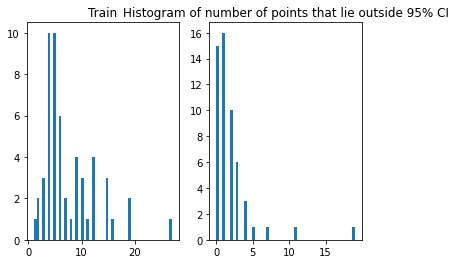

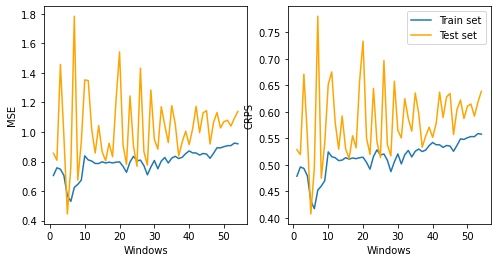

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.08788539594993965
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,64.81406455865962
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.0005825609193208504
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.5244079987162442
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,76.67240570214788
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9412542127843545
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[9.96508820e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[5.15194384e-01, 0.00000000e+00, 0.00000000e+00..."


In [21]:
slidingwindow_alg(60, 6, epochs=30, l0=77, p=77)

iterations to go through, plot:  54 [27, 53]


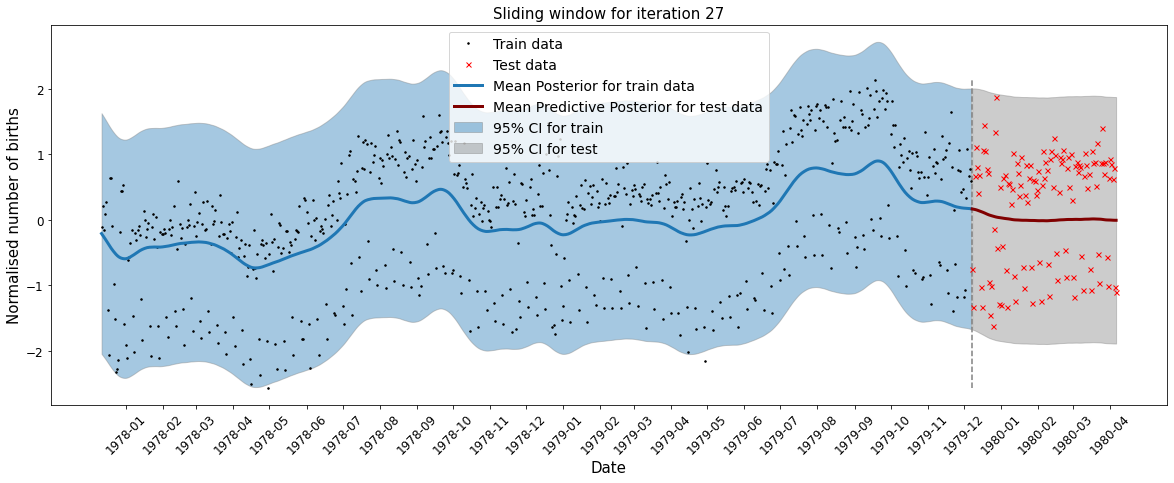

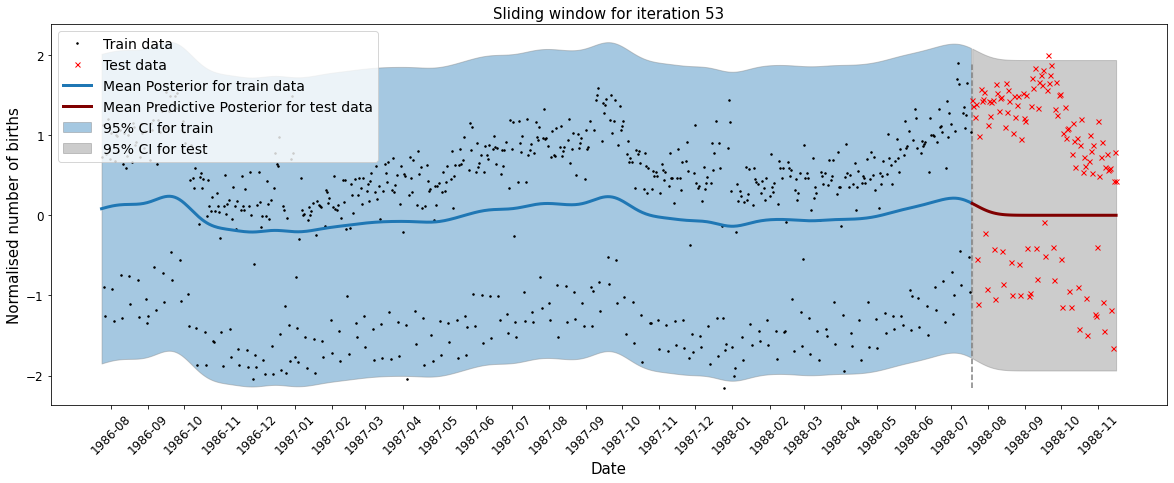

ELBO Avg:  -989.9522764914853
Train Avg. MSE, points outside CI:  0.7928489659538472 4.555555555555555
Test Avg. MSE, points outside CI:  1.147532363978937 4.037037037037037
CRPS train, test:  0.5134826755197287 0.6198849490760552


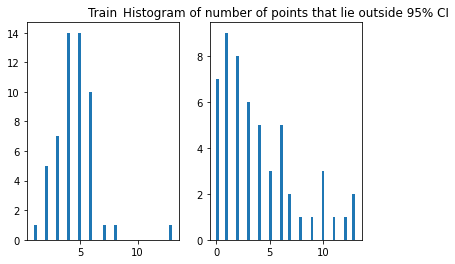

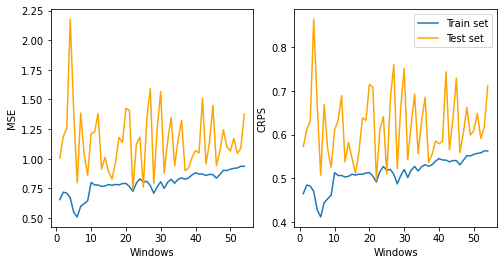

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.024780629615939614
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,13.928275734102224
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,1.1651716677531208e-05
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.499261683170502
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,76.83582181911552
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9502832463518814
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[5.21268465e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[8.81988249e-01, 0.00000000e+00, 0.00000000e+00..."


In [22]:
slidingwindow_alg(60, 6, epochs=30, l0=7, p=77)

iterations to go through, plot:  54 [27, 53]


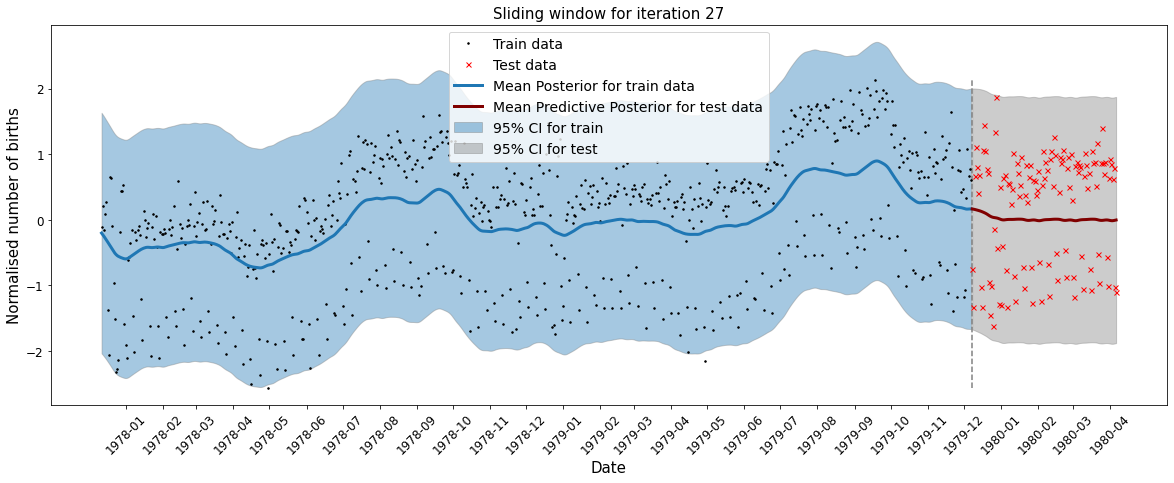

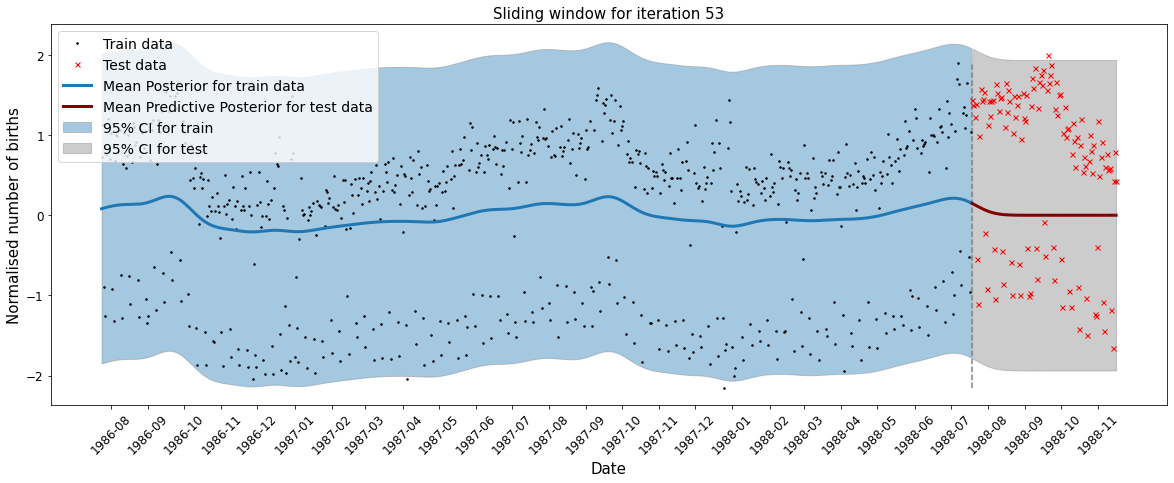

ELBO Avg:  -990.19978880051
Train Avg. MSE, points outside CI:  0.7939833581021806 4.555555555555555
Test Avg. MSE, points outside CI:  1.1449832081165627 4.0
CRPS train, test:  0.5138749658085539 0.6192503943172503


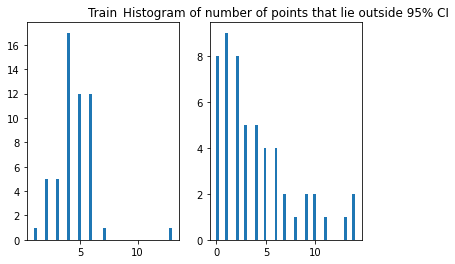

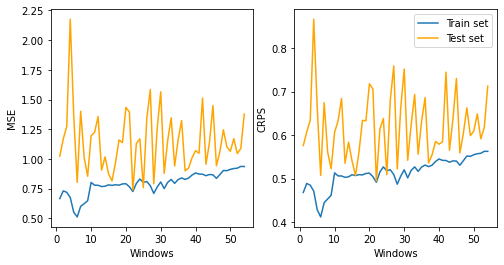

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.024634609734784818
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,13.864535269258937
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,1.6854740113040124e-05
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.5006204320340775
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,30.41775922772943
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.950362783877063
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[5.19524697e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[8.82946638e-01, 0.00000000e+00, 0.00000000e+00..."


In [24]:
slidingwindow_alg(60, 6, epochs=30, l0=7, p=30)

iterations to go through, plot:  54 [27, 53]


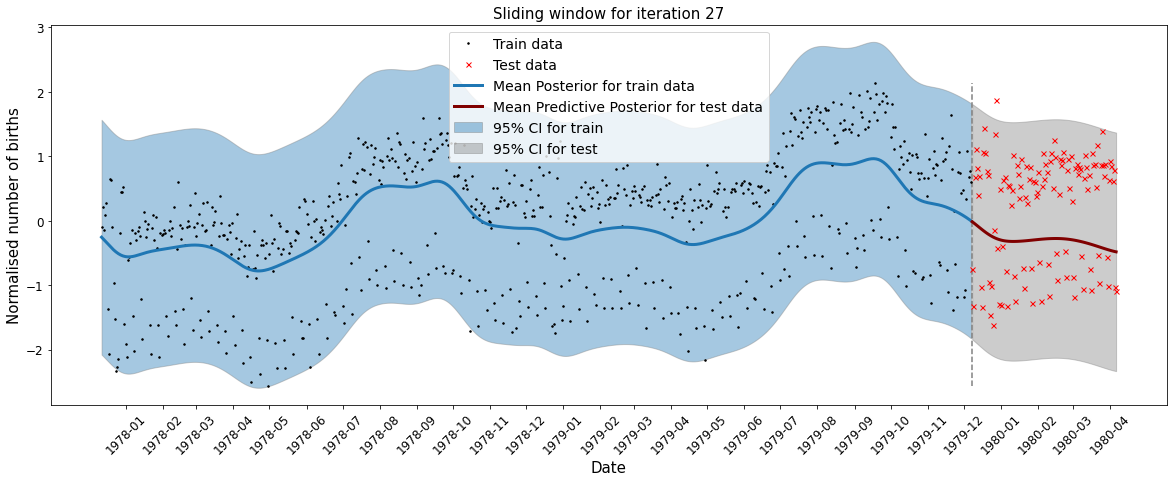

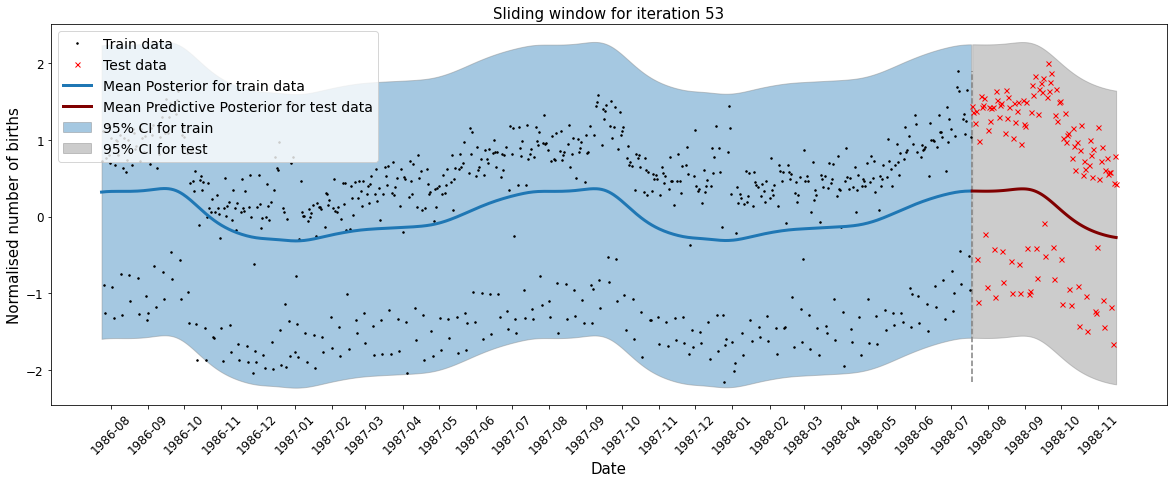

ELBO Avg:  -976.711978086713
Train Avg. MSE, points outside CI:  0.7875448291536751 4.296296296296297
Test Avg. MSE, points outside CI:  1.0669020650135765 2.5185185185185186
CRPS train, test:  0.5117890343907624 0.6019938645706207


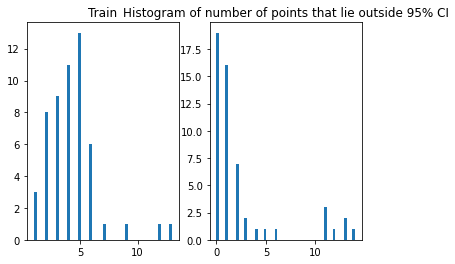

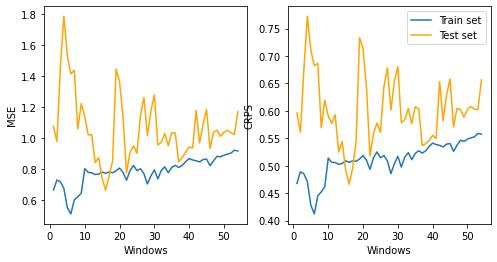

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.0010249189116453893
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,11.67283522389994
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.0892494516739019
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.5127345990195478
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,358.0408431364324
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9425094299374863
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[1.06661915e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[3.38627784e-01, 0.00000000e+00, 0.00000000e+00..."


In [23]:
slidingwindow_alg(60, 6, epochs=30, l0=7, p=365)

iterations to go through, plot:  54 [27, 53]


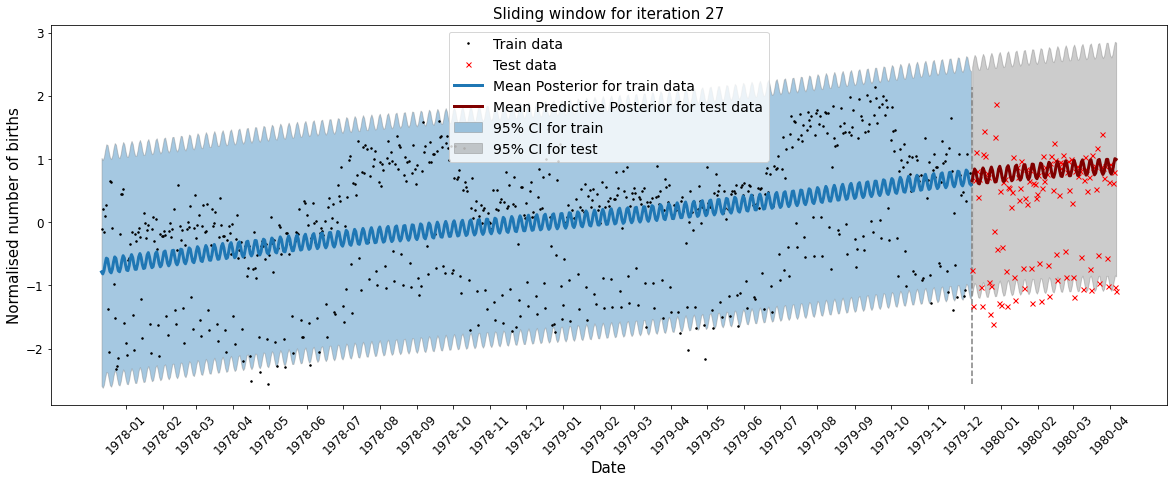

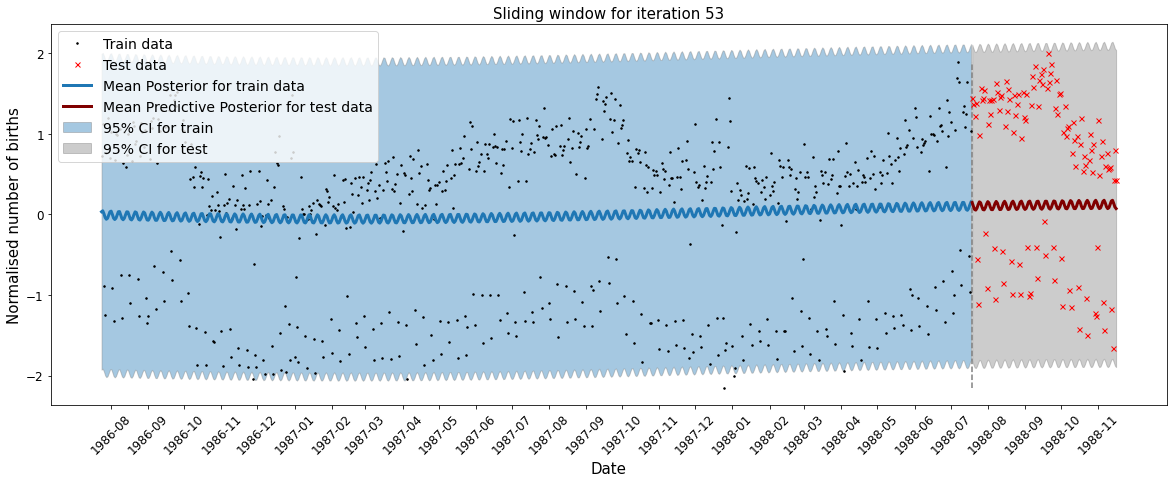

ELBO Avg:  -1002.0503027607978
Train Avg. MSE, points outside CI:  0.8992682719642213 17.185185185185187
Test Avg. MSE, points outside CI:  1.2317633433651947 9.092592592592593
CRPS train, test:  0.5426917715734484 0.6413416792945791


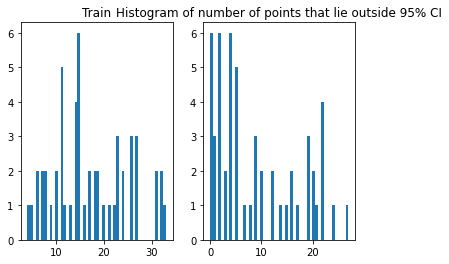

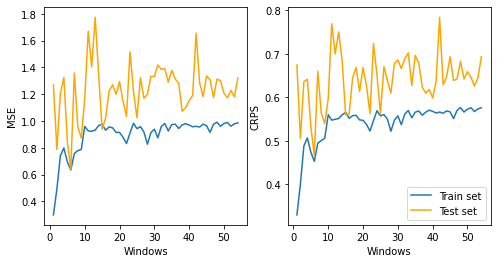

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.04895484678851476
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,353.5535494679371
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.004509642669061141
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.6130059240457895
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,6.901184944288549
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9917318622772134
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[1.45596243e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[3.85382810e-01, 0.00000000e+00, 0.00000000e+00..."


In [25]:
slidingwindow_alg(60, 6, epochs=30, l0=365, p=7)

iterations to go through, plot:  54 [27, 53]


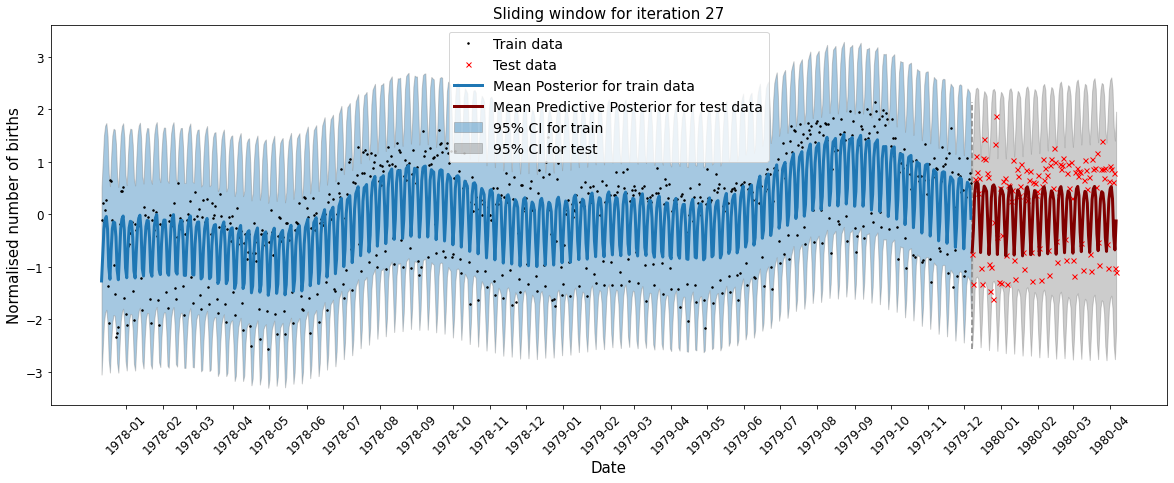

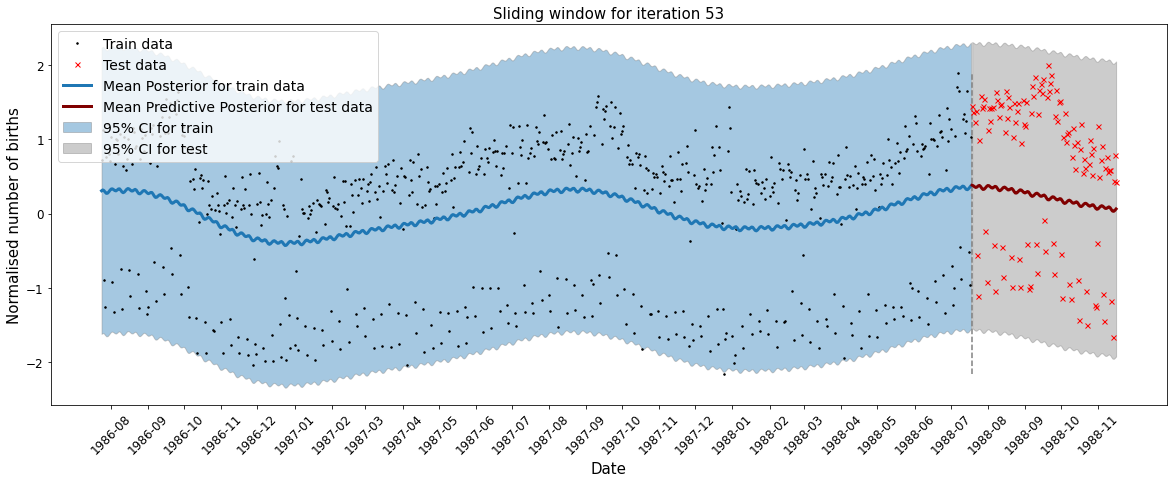

ELBO Avg:  -866.0359922683327
Train Avg. MSE, points outside CI:  0.5424924841644455 5.555555555555555
Test Avg. MSE, points outside CI:  0.8383808016555494 2.1296296296296298
CRPS train, test:  0.4201857943106174 0.5209308715613425


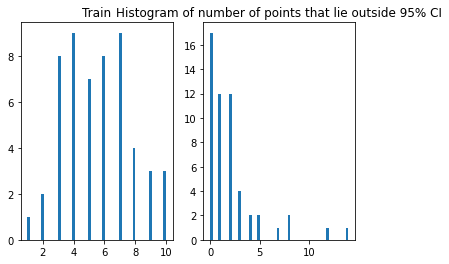

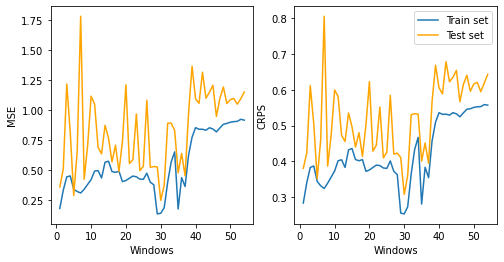

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.08296282319804119
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,65.20382451230917
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.0034785313054850383
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.49297146274173825
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,13.53349601925485
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9388044794953603
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[1.04573521e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[5.27770562e-01, 0.00000000e+00, 0.00000000e+00..."


In [26]:
slidingwindow_alg(60, 6, epochs=30, l0=77, p=14)

iterations to go through, plot:  54 [27, 53]


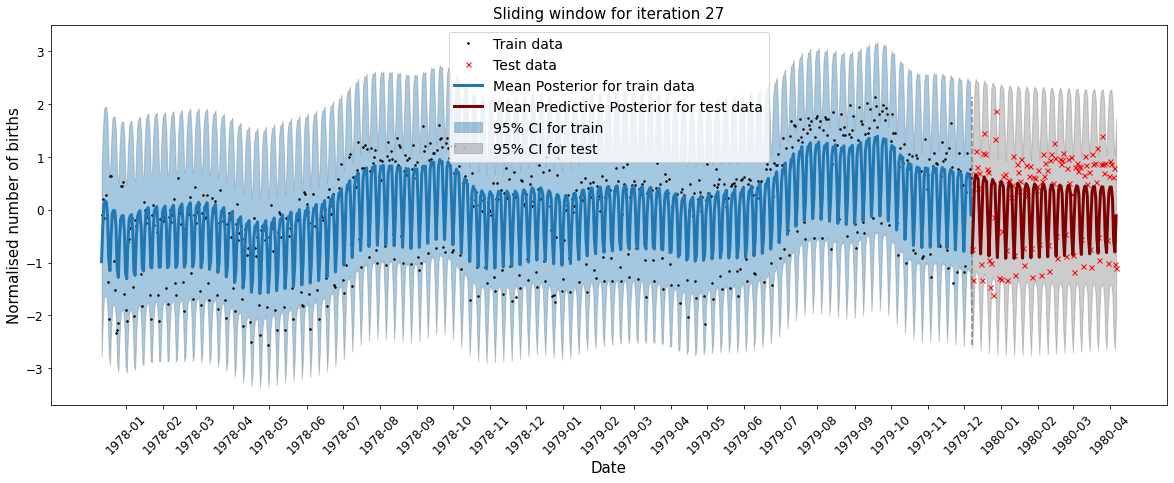

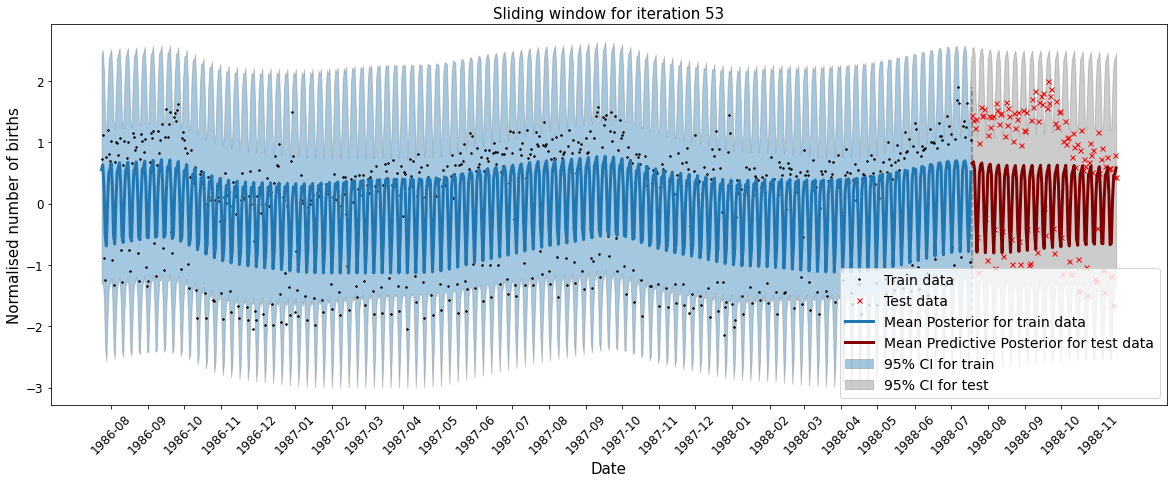

ELBO Avg:  -828.6006311878326
Train Avg. MSE, points outside CI:  0.39592198184762 5.222222222222222
Test Avg. MSE, points outside CI:  0.7950000302937952 3.037037037037037
CRPS train, test:  0.36997998320986886 0.5064107693204631


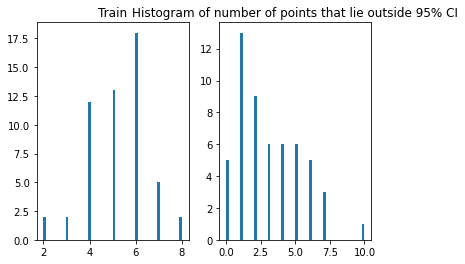

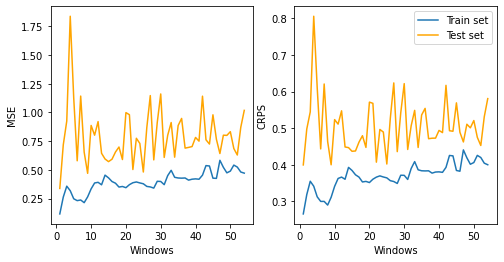

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.012877405724364811
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,17.948439128000437
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.09375141991760139
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.21951090174148782
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,6.982410149738788
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.8826638928621817
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[1.69888096e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[5.12615632e-01, 0.00000000e+00, 0.00000000e+00..."


In [27]:
slidingwindow_alg(60, 6, epochs=30, l0=7, p=7)

In [ ]:
slidingwindow_alg(121, 5, epochs=30, l0=30, p=30)

In [ ]:
slidingwindow_alg(243, 11, epochs=30, l0=77)

In [ ]:
slidingwindow_alg(243, 11, epochs=30, l0=30)

In [ ]:
slidingwindow_alg(243, 11, epochs=30, l0=7)